<a href="https://colab.research.google.com/github/yu8867/SRS/blob/main/SRS_unsteady.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import math
import warnings
warnings.simplefilter('ignore', category=RuntimeWarning)
import random

In [ ]:
class Agent_Unsteady:
  def __init__(self, E, arm_times, arm_random_p, arm_size, gamma):
    self.E = E
    self.arm_times = arm_times
    self.arm_random_p = arm_random_p
    self.arm_size  = arm_size
    self.w = np.array([10**-7]*arm_size)
    self.l = np.array([10**-7]*arm_size)  
    self.gamma = gamma
    self.success = np.zeros(len(E))
    self.fail = np.zeros(len(E))
  
  def initialize(self):
    self.E = np.array([0.5] * self.arm_size)
    self.arm_times = np.array([10**-7] * self.arm_size)
    self.arm_random_p = np.array([0] * self.arm_size)
    self.w = np.array([10**-7] * self.arm_size)
    self.l = np.array([10**-7] * self.arm_size)
    self.success = np.zeros(self.arm_size)
    self.fail = np.zeros(self.arm_size)   

  def updata(self, reward, action):
    # print("\nw_before = ",self.w)
    # print("l_before = ",self.l,"\n")
    if reward == 1:
      self.w = [self.gamma*self.w[i] if i!=action else self.gamma*self.w[i]+1 for i in range(len(self.w))]
      self.l = self.gamma * np.array(self.l)

    elif reward == 0:
      self.l = [self.gamma*self.l[i] if i!=action else self.gamma*self.l[i]+1 for i in range(len(self.l))]
      self.w = self.gamma * np.array(self.w)

    self.arm_times[action] = self.w[action]  + self.l[action]
    self.E[action] = self.w[action]/ (self.w[action]  + self.l[action])
    # self.E[action] = ((self.arm_times[action]-1)/self.arm_times[action])*self.E[action] + (1/self.arm_times[action]) * reward
    # print("w_after = ",self.w)
    # print("l_after = ",self.l)
    if reward == 1:
      self.success[action] = self.success[action] +1
    elif reward == 0:
      self.fail[action] = self.fail[action] + 1

  def random_prob(self, size):
    self.arm_random = np.random.rand(size)
    return self.arm_random     

  def reward(self, p, action):
    if random.random() < p[action]:
      return 1.0
    else:
      return 0.0  

def shuffle_all_move(items):
    rand_ord = random.sample(range(len(items)), k=len(items))
    return [items[r] for i, r in sorted(zip(rand_ord, rand_ord[1:]+rand_ord[:1]))]

#方策

In [ ]:
######################################
class SRS:
  def __init__(self, aleph, opt, epsilon):
    self.aleph = aleph
    self.epsilon = epsilon

  def select_arm(self, E, arm_times, N, agent):
    if  E.max() > self.aleph:
      E = E - E.max() + self.aleph - self.epsilon

    Z = 1/(np.sum(1/(self.aleph - E)))
    row = Z / (self.aleph - E)
    b = (arm_times / row) - N + self.epsilon

    SRS = (N + b.max()) * row - arm_times
    pi = SRS/np.sum(SRS)

    return np.random.choice(len(pi),p=pi)

######################################
#SRS-CHはdesktopの方に回答ある
class SRS_CH:
  def __init__(self, p, epsilon):
    self.aleph = 1.0
    self.epsilon = epsilon

  def select_arm(self, E, arm_times, N, agent):
    E_max = E.max()
    DKL = E*np.log(E/E_max) + (1-E)*np.log((1-E)/(1-E_max))
    myu_ch_list = np.exp((-1)*arm_times*DKL)
    aleph = np.nan_to_num(E_max*(1-(E*myu_ch_list/E_max))/(1-myu_ch_list), nan=0)

    updata_aleph = aleph.max()
    if  E.max() > updata_aleph:
      E = E - E.max() + updata_aleph - self.epsilon  
        
    RS = (-1)*(arm_times/N)*(E - updata_aleph)
    row = RS / (aleph - E)

    b = (arm_times / row) - N + self.epsilon
    # b = (N * row - arm_times)/row

    SRS = (N + b.max()) * row - arm_times
    # SRS = np.array([self.epsilon if i<0 else i for i in SRS])

    pi = SRS/np.sum(SRS)
    return np.random.choice(len(pi),p=pi)

######################################
class SRS_OPT:
  def __init__(self, aleph, opt, epsilon):
    # p = sorted(p,reverse=True)
    # self.aleph = (p[0] + p[1])/2
    self.aleph = opt
    self.epsilon = epsilon

  def select_arm(self, E, arm_times, N, agent):
    if  E.max() > self.aleph:
      E = E - E.max() + self.aleph - self.epsilon

    Z = 1/(np.sum(1/(self.aleph - E)))
    row = Z / (self.aleph - E)

    b = (arm_times / row) - N + self.epsilon

    SRS = (N + b.max()) * row - arm_times

    pi = SRS/np.sum(SRS)
    return np.random.choice(len(pi),p=pi)

######################################
class RS:
  def __init__(self, aleph, opt, epsilon):
    # self.aleph = p.max()
    self.epsilon = epsilon
    self.aleph = aleph

  def select_arm(self, E, arm_times, N, agent):
    RS = (arm_times / np.sum(arm_times))*(E - self.aleph)
    
    return np.argmax(RS)

######################################
class RS_OPT:
  def __init__(self, aleph, opt, epsilon):
    # p = sorted(p,reverse=True)
    # self.aleph = (p[0] + p[1])/2
    self.aleph =  opt

  def select_arm(self, E, arm_times, N, agent):
    # RS = (arm_times / N)*(E - self.aleph)
    RS = (arm_times / np.sum(arm_times))*(E - self.aleph)   
    
    return np.argmax(RS)

######################################
class TS:
  def __init__(self, aleph, opt, epsilon):
    self.epsilon = epsilon
  
  def select_arm(self, E, arm_times, N, agent):
    myu = np.array([np.random.beta(agent.success[action]+1, agent.fail[action]+1) for action in range(agent.arm_size)])
    return np.argmax(myu)

In [ ]:
class Simulater:
  def __init__(self, n_sim, steps, arm_size, epsilon, gamma):
    self.steps = steps
    self.n_sim = n_sim
    self.arm_size = arm_size
    self.epsilon = epsilon
    self.gamma = gamma
    
  def test(self, policy, Agent):
    agent = Agent(np.array([0.5]*self.arm_size), np.array([10**-7]*self.arm_size), np.zeros(self.arm_size), self.arm_size, self.gamma)
    regret = np.zeros((self.n_sim, self.steps))

    for sim in tqdm(range(self.n_sim)):  
      p = agent.random_prob(self.arm_size)
      aleph = p.max()
      opt = np.sum(sorted(p,reverse=True)[0:2])/2
      pi = policy(aleph, opt, self.epsilon)
      for step in range(0, self.steps):
        if (step > 40) and (step%2000==0):
          p = shuffle_all_move(p)
        action = pi.select_arm(agent.E, agent.arm_times, step+1, agent)
        reward = agent.reward(p,action)
        agent.updata(reward, action)
        regret[sim, step] += regret[sim, step-1] + np.max(p) - p[action]
      agent.initialize()
    return regret

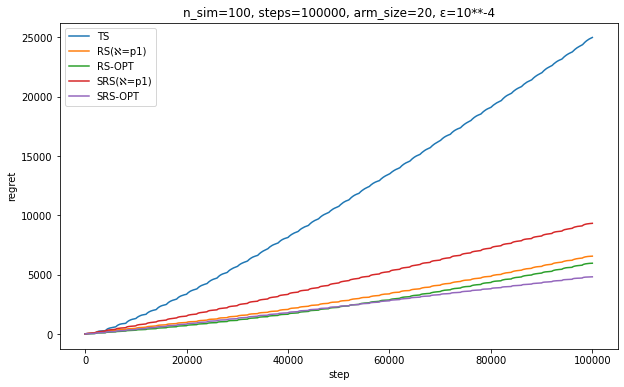

In [ ]:
simulata = Simulater(n_sim=100, steps= 100000, arm_size=20, epsilon=10**-4, gamma=0.999)
regret_TS = simulata.test(TS, Agent_Unsteady)
regret_RS = simulata.test(RS, Agent_Unsteady)
regret_RS_OPT = simulata.test(RS_OPT, Agent_Unsteady)
regret_SRS = simulata.test(SRS, Agent_Unsteady)
regret_SRS_OPT = simulata.test(SRS_OPT, Agent_Unsteady)

plt.figure(figsize=(10,6))
plt.xlabel("step")
plt.ylabel("regret")

plt.plot(np.mean(regret_TS, axis=0), label="TS")
plt.plot(np.mean(regret_RS, axis=0), label="RS(ℵ=p1)")
plt.plot(np.mean(regret_RS_OPT, axis=0), label="RS-OPT")
plt.plot(np.mean(regret_SRS, axis=0), label="SRS(ℵ=p1)")
plt.plot(np.mean(regret_SRS_OPT, axis=0), label="SRS-OPT")

plt.title("n_sim=100, steps=100000, arm_size=20, ε=10**-4")
plt.legend()
plt.savefig("result-SRS.jpg")
plt.show()

In [ ]:
# np.save("regret_TS",regret_TS)
# np.save("regret_RS",regret_RS)
# np.save("regret_RS_OPT",regret_RS_OPT)
# np.save("regret_SRS",regret_SRS)
# np.save("regret_SRS_OPT",regret_SRS_OPT)